# Importing Required Libraries

In [882]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

# Load

In [883]:
df = pd.read_excel("Processed_Flipdata.xlsx")
df.head()

,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


In [884]:
df.tail()

,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
536,637,SAMSUNG Galaxy S23 5G,Cream,256,8,3900,50MP,12MP,0,15.49,Qualcomm Snapdragon 8 Gen 2,79999
537,638,LAVA Z21,Cyan,32,2,3100,5MP,2MP,0,12.70,Octa Core,5998
538,639,Tecno Spark 8T,Turquoise Cyan,64,4,5000,50MP,8MP,0,16.76,MediaTek Helio G35,9990
539,641,SAMSUNG Galaxy A54 5G,Awesome Lime,128,8,5000,50MP,32MP,0,16.26,"Exynos 1380, Octa Core",38999
540,642,OPPO A77,Sky Blue,128,4,5000,50MP,8MP,0,16.66,Mediatek Helio G35,15999


# Testing Setup

In [885]:
print(df.shape)
print(df.columns)

(541, 12)
Index(['Unnamed: 0', 'Model', 'Colour', 'Memory', 'RAM', 'Battery_',
       'Rear Camera', 'Front Camera', 'AI Lens', 'Mobile Height', 'Processor_',
       'Prize'],
      dtype='object')


# Quick cleanup: drop unnamed index column if present

In [886]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Standardize column names

In [887]:
df.columns = [c.strip() for c in df.columns]
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (541, 11)
Columns: ['Model', 'Colour', 'Memory', 'RAM', 'Battery_', 'Rear Camera', 'Front Camera', 'AI Lens', 'Mobile Height', 'Processor_', 'Prize']


# Show top rows

In [888]:
from IPython.display import display, HTML
display(HTML('<h3>Dataset Head</h3>'))
display(df.head())

,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


# ---------- Data cleaning ------------


# Trim whitespace in string columns


In [889]:
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# Rename Prize -> Price if present

In [890]:
if 'Prize' in df.columns:
    df.rename(columns={'Prize':'Price'}, inplace=True)

Convert numeric-like columns that may contain units (e.g., '13MP') to numeric


In [891]:
def mp_to_num(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).upper()
        s = s.replace("MP","").replace("M P","").replace(" ","")
        return float(s)
    except:
        return np.nan

Columns: Rear Camera, Front Camera, Battery_, Memory, RAM, AI Lens, Mobile Height


In [892]:
if 'Rear Camera' in df.columns:
    df['Rear_MP'] = df['Rear Camera'].apply(mp_to_num)
if 'Front Camera' in df.columns:
    df['Front_MP'] = df['Front Camera'].apply(mp_to_num)
# Battery may be numeric but with trailing characters
if 'Battery_' in df.columns:
    df['Battery_mAh'] = pd.to_numeric(df['Battery_'], errors='coerce')

# Memory and RAM to numeric


In [893]:
for col in ['Memory','RAM','AI Lens','Mobile Height']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Price to numeric


In [ ]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Check missing values after parsing

In [895]:
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing_summary.head(15))


Missing values per column:
 Model            0
Colour           0
Memory           0
RAM              0
Battery_         0
Rear Camera      0
Front Camera     0
AI Lens          0
Mobile Height    0
Processor_       0
Price            0
Rear_MP          0
Front_MP         0
Battery_mAh      0
dtype: int64


Simple imputation strategy: for numeric columns, fill with median; for categorical, fill with 'Unknown'


In [896]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

df[cat_cols] = df[cat_cols].fillna('Unknown')

# ---------- Univariate analysis ----------


Histograms for key numeric features


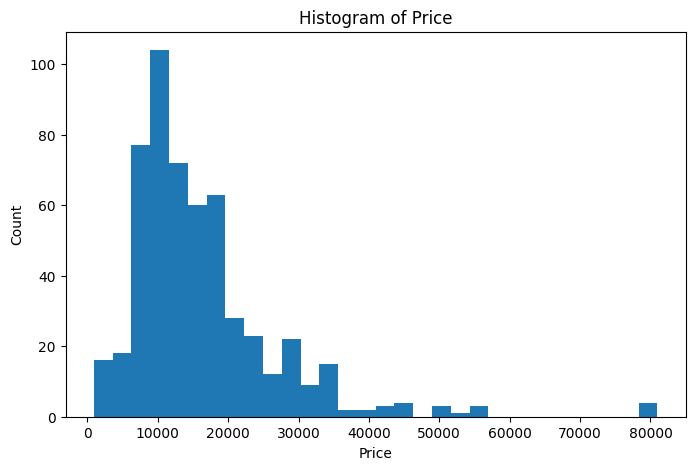

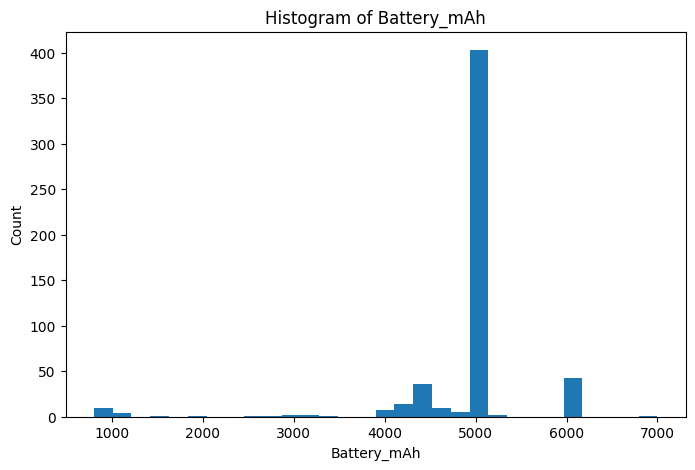

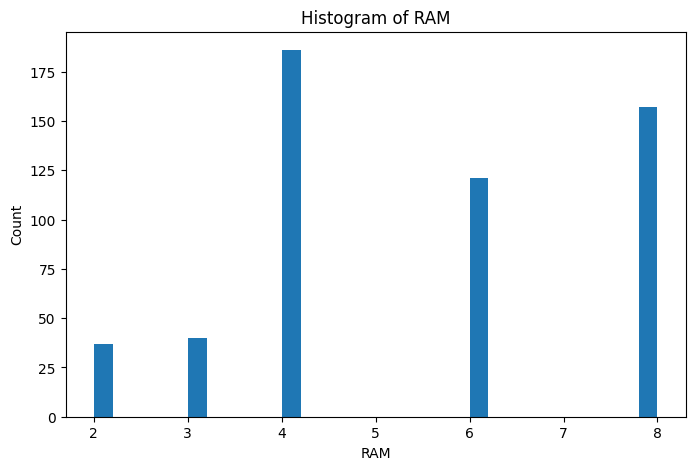

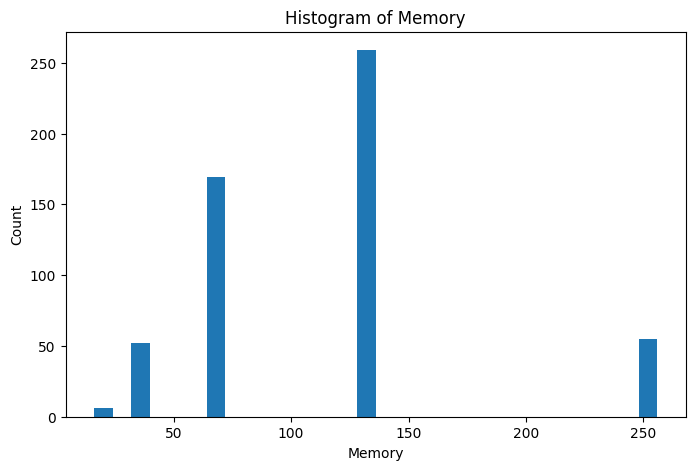

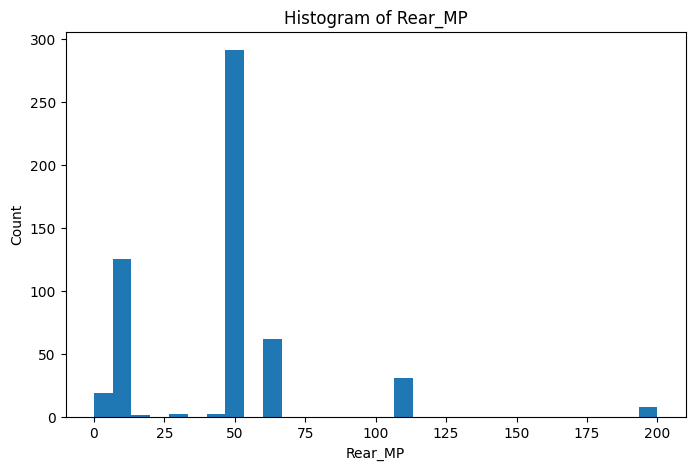

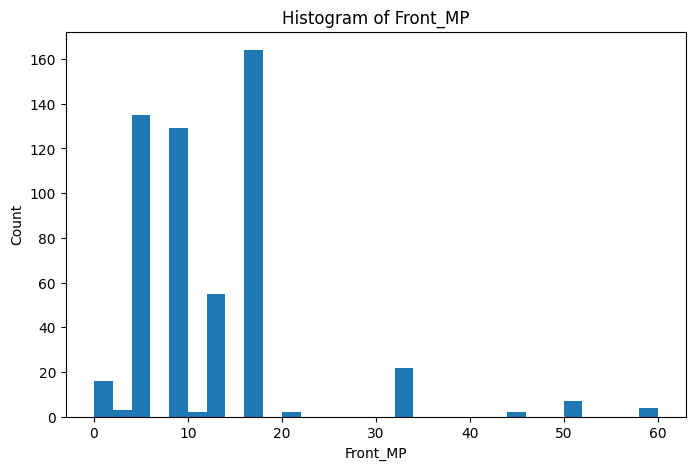

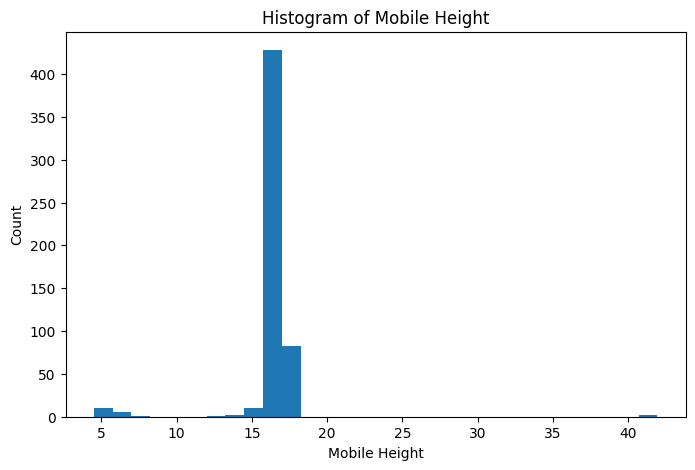

In [940]:
numeric_to_plot = ['Price','Battery_mAh','RAM','Memory','Rear_MP','Front_MP','Mobile Height']
numeric_to_plot = [c for c in numeric_to_plot if c in df.columns]

for col in numeric_to_plot:
    plt.figure(figsize=(8,5))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()

# Boxplots to inspect outliers

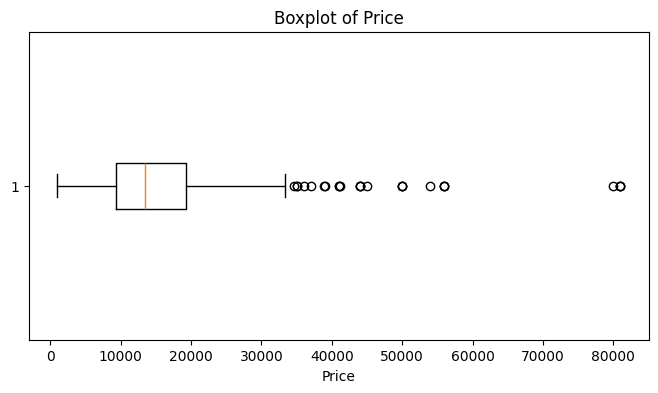

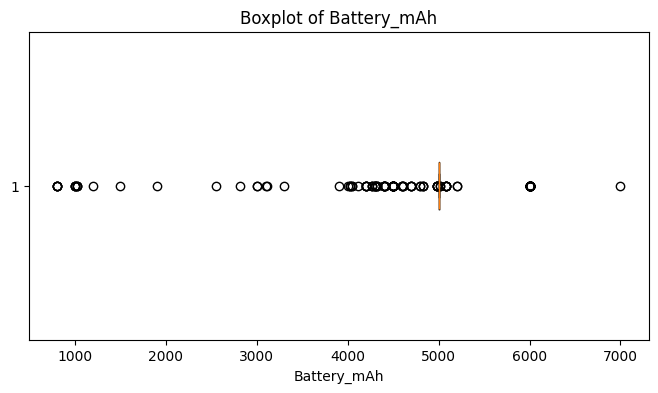

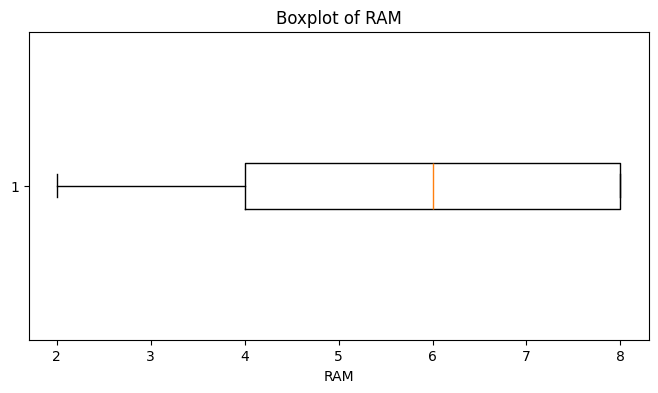

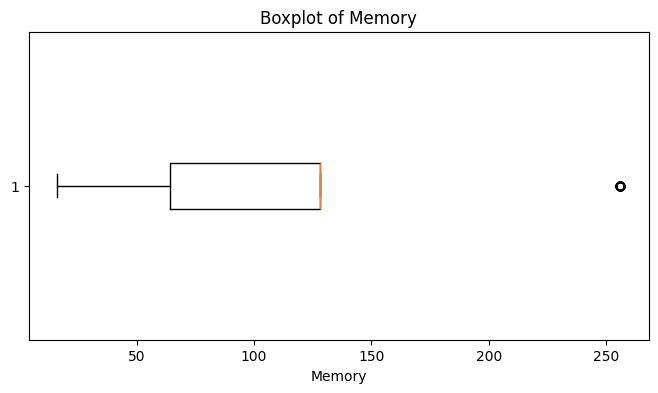

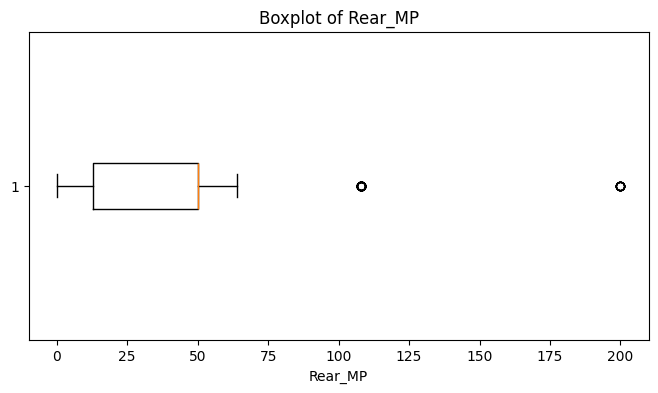

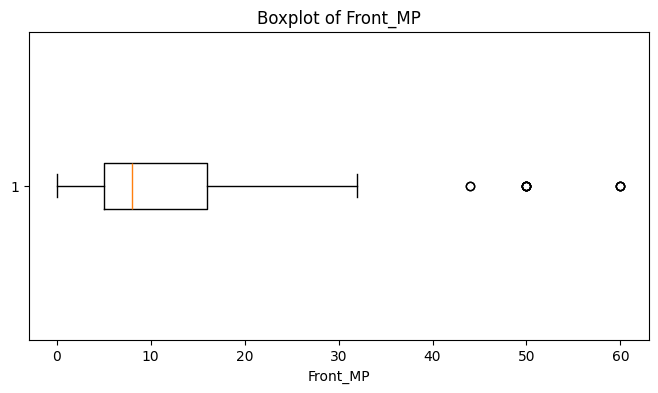

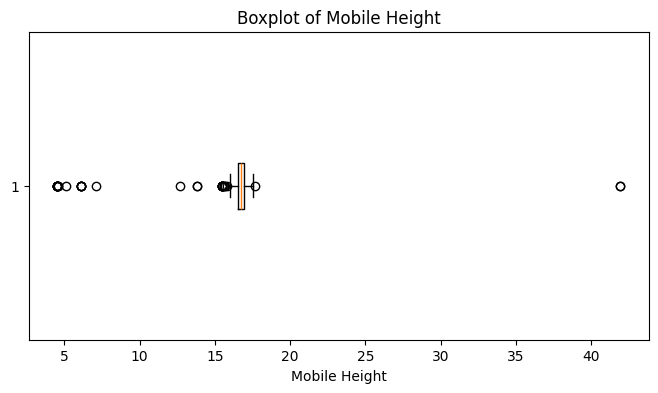

In [1025]:
for col in numeric_to_plot:
    plt.figure(figsize=(8,4))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

## Value counts for categorical features (top categories)


Top values for Model:
 Model
realme C55               9
vivo Y16                 9
REDMI Note 12 Pro 5G     9
SAMSUNG Galaxy A14 5G    9
SAMSUNG Galaxy F14 5G    8
REDMI 10                 8
vivo T2x 5G              8
vivo T1 44W              8
Infinix HOT 30i          8
SAMSUNG Galaxy F13       6
Name: count, dtype: int64


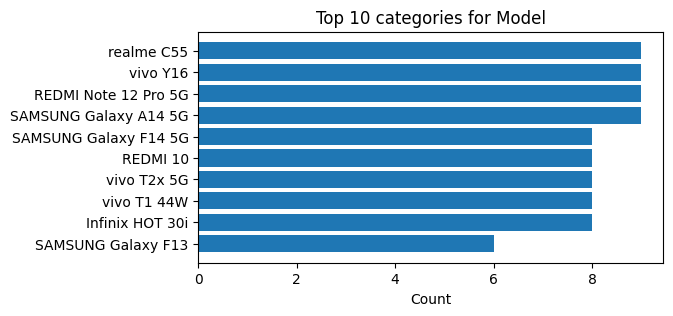


Top values for Colour:
 Colour
Yellow            12
Black              8
Power Black        8
Royal Blue         8
Midnight Black     7
Cool Blue          7
Aqua Blue          6
Force Black        6
Glacier Blue       6
OMG Black          5
Name: count, dtype: int64


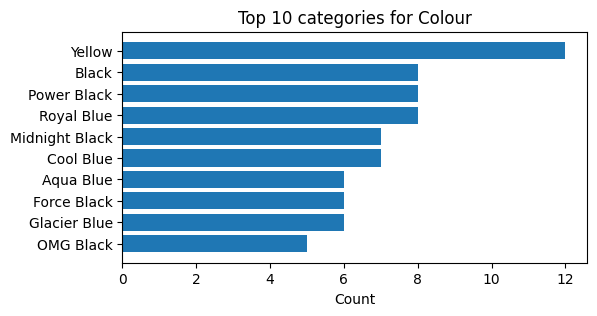


Top values for Processor_:
 Processor_
Qualcomm Snapdragon 680       33
Unisoc T612                   21
Mediatek Helio A22            19
Mediatek Dimensity 1080       18
Qualcomm Snapdragon 695 5G    17
Mediatek Helio P35            16
Mediatek Helio G85            10
Mediatek Dimensity 810        10
Helio G88                     10
Mediatek Dimensity 810 5G     10
Name: count, dtype: int64


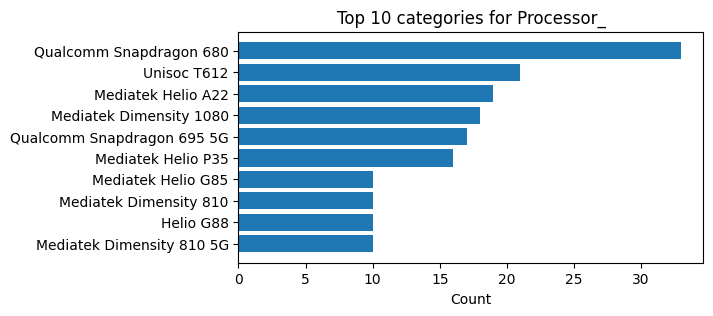

In [1026]:
cat_to_show = ['Model','Colour','Processor_']
for col in cat_to_show:
    if col in df.columns:
        top = df[col].value_counts().nlargest(10)
        print(f"\nTop values for {col}:\n", top)
        plt.figure(figsize=(6,3))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f'Top 10 categories for {col}')
        plt.xlabel('Count')
        plt.show()

# ---------- Bivariate analysis ----------

Scatter plots of Price vs a few numerical features

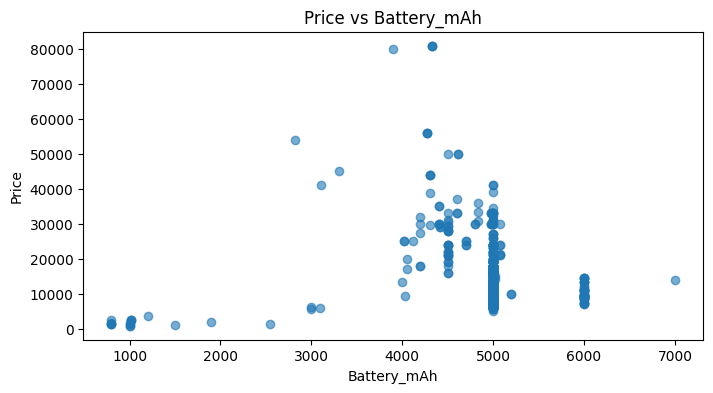

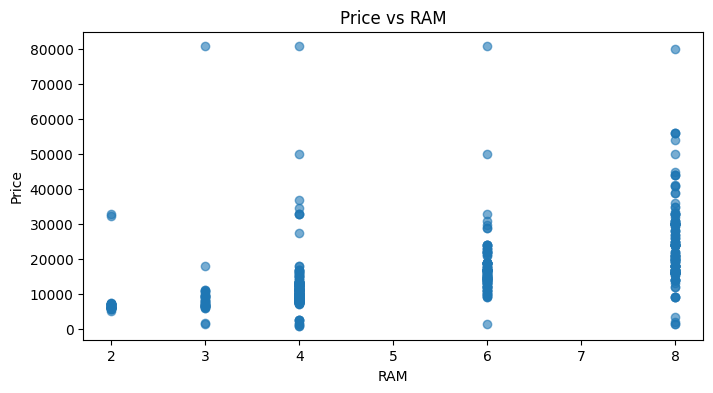

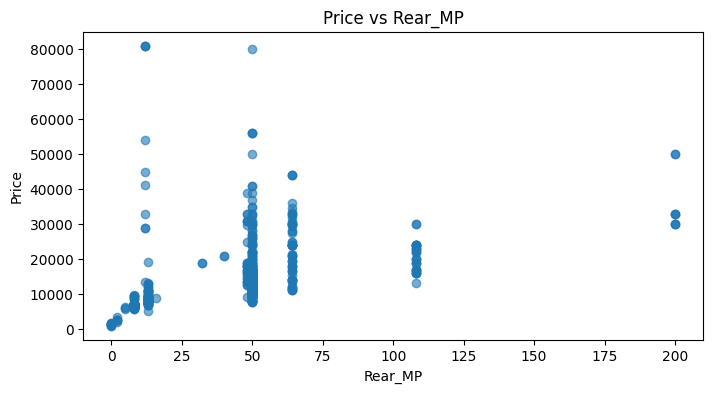

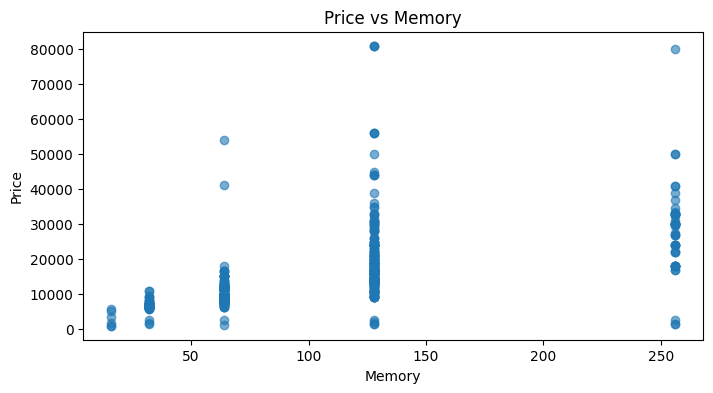

In [1067]:
pairs = [('Price','Battery_mAh'), ('Price','RAM'), ('Price','Rear_MP'), ('Price','Memory')]
for x,y in pairs:
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(8,4))
        plt.scatter(df[y], df[x], alpha=0.6)
        plt.xlabel(y); plt.ylabel(x)
        plt.title(f'{x} vs {y}')
        plt.show()

Boxplot of Price by AI Lens (0/1)


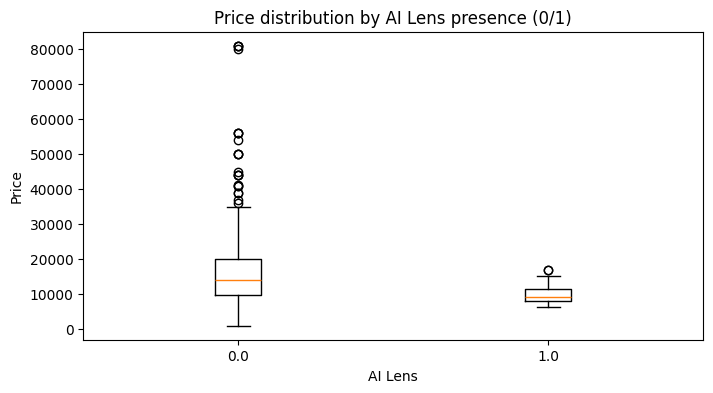

In [1107]:
if 'AI Lens' in df.columns:
    plt.figure(figsize=(8,4))
    groups = [df[df['AI Lens']==v]['Price'] for v in sorted(df['AI Lens'].unique())]
    plt.boxplot(groups, labels=[str(v) for v in sorted(df['AI Lens'].unique())])
    plt.title('Price distribution by AI Lens presence (0/1)')
    plt.xlabel('AI Lens'); plt.ylabel('Price')
    plt.show()

Price by top Model categories (show top 8 models)

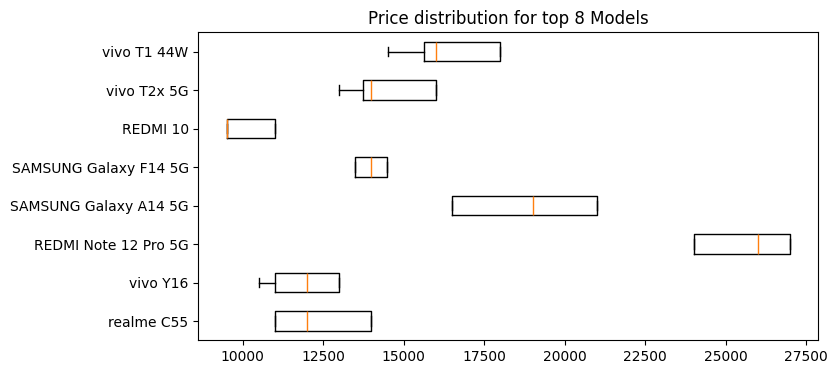

In [1108]:
if 'Model' in df.columns:
    top_models = df['Model'].value_counts().nlargest(8).index.tolist()
    subset = df[df['Model'].isin(top_models)]
    plt.figure(figsize=(8,4))
    data_to_plot = [subset[subset['Model']==m]['Price'] for m in top_models]
    plt.boxplot(data_to_plot, labels=top_models, vert=False)
    plt.title('Price distribution for top 8 Models')
    plt.show()

# ---------- Multivariate analysis ----------

Correlation matrix heatmap (numeric features)


Correlation matrix (numeric):
                   Price
Price          1.000000
Memory         0.566660
Front_MP       0.532321
RAM            0.532024
Rear_MP        0.410367
Mobile Height  0.176009
Battery_mAh   -0.034297
Battery_      -0.034297
AI Lens       -0.153691


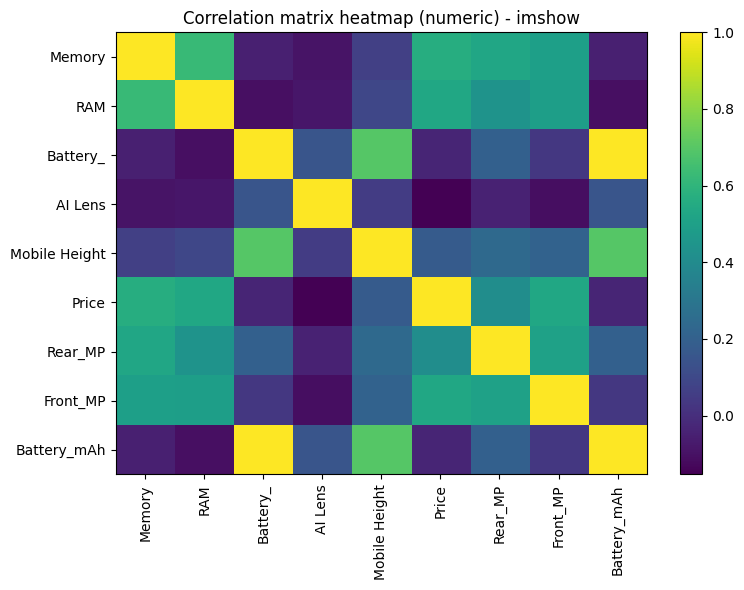

In [1109]:
corr = df[num_cols].corr()
print("\nCorrelation matrix (numeric):\n", corr[['Price']].sort_values(by='Price', ascending=False).head(10))

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix heatmap (numeric) - imshow')
plt.tight_layout()
plt.show()

Scatter matrix for selected numeric features (pairwise scatter plots)

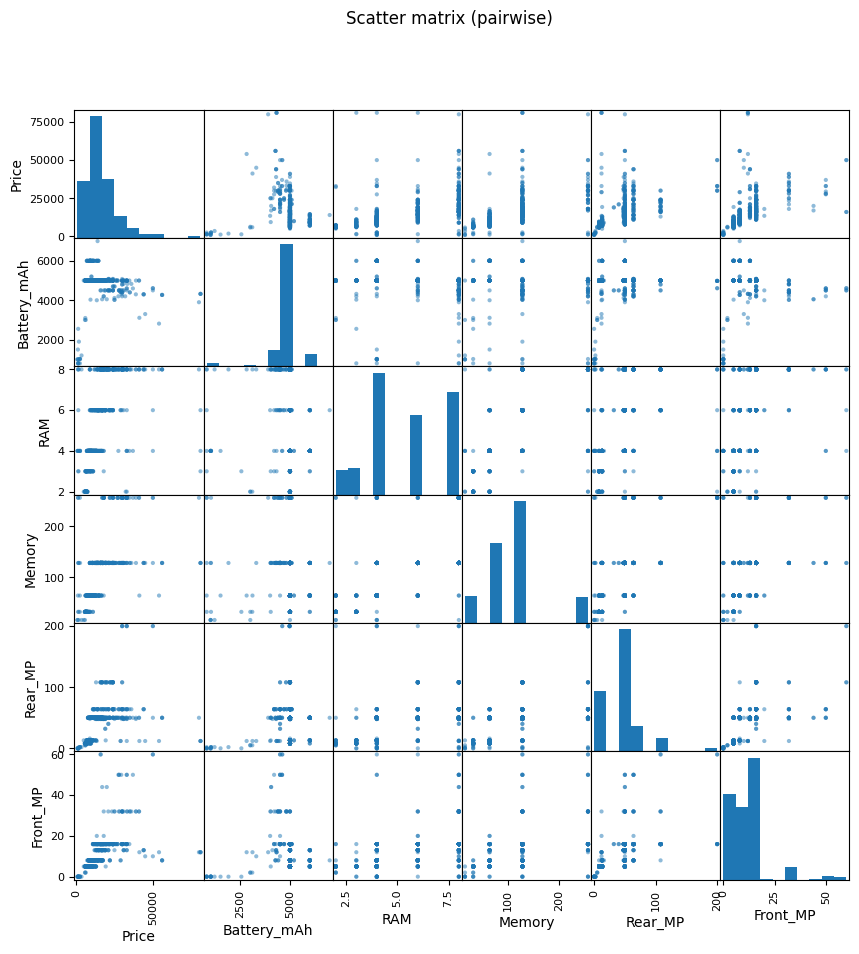

In [1110]:
sel = [c for c in ['Price','Battery_mAh','RAM','Memory','Rear_MP','Front_MP'] if c in df.columns]
if len(sel) <= 6 and len(sel) >= 4:
    scatter_matrix(df[sel], figsize=(10,10), diagonal='hist')
    plt.suptitle('Scatter matrix (pairwise)')
    plt.show()

---------- Feature engineering / extraction (add new columns) ----------


1. Total camera MP (rear + front)

In [1111]:
if 'Rear_MP' in df.columns and 'Front_MP' in df.columns:
    df['Total_Camera_MP'] = df['Rear_MP'] + df['Front_MP']

2. Camera ratio (rear/front) - handle division safely


In [1112]:
if 'Rear_MP' in df.columns and 'Front_MP' in df.columns:
    df['Rear_to_Front_Ratio'] = df['Rear_MP'] / (df['Front_MP'].replace({0:np.nan}))
    df['Rear_to_Front_Ratio'] = df['Rear_to_Front_Ratio'].fillna(0)

3. Battery per GB RAM

In [1113]:
if 'Battery_mAh' in df.columns and 'RAM' in df.columns:
    df['Battery_per_RAM'] = df['Battery_mAh'] / (df['RAM'].replace({0:np.nan}))
    df['Battery_per_RAM'] = df['Battery_per_RAM'].fillna(df['Battery_per_RAM'].median())

4. Frequency encoding for Model (to avoid exploding one-hot)

In [1114]:
if 'Model' in df.columns:
    freq = df['Model'].value_counts(normalize=True)
    df['Model_freq'] = df['Model'].map(freq)

5. Simplify Processor_ to primary brand/keyword (first token)

In [1115]:
if 'Processor_' in df.columns:
    df['Processor_brand'] = df['Processor_'].apply(lambda x: str(x).split()[0] if pd.notna(x) else 'Unknown')

6. Price buckets (for analysis)

In [1116]:
df['Price_bucket'] = pd.qcut(df['Price'], q=4, labels=['Low','Medium','High','Premium'])

# Show added columns

In [1117]:
new_cols = ['Total_Camera_MP','Rear_to_Front_Ratio','Battery_per_RAM','Model_freq','Processor_brand','Price_bucket']
present_new = [c for c in new_cols if c in df.columns]
print("\nNew columns added:", present_new)
from IPython.display import display, HTML
display(HTML('<h3>Enhanced Dataset Sample (with new features)</h3>'))
display(df.head())


New columns added: ['Total_Camera_MP', 'Rear_to_Front_Ratio', 'Battery_per_RAM', 'Model_freq', 'Processor_brand', 'Price_bucket']


,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,...,Front_MP,Battery_mAh,Total_Camera_MP,Rear_to_Front_Ratio,Battery_per_RAM,Model_freq,Processor_brand,Price_bucket,Processor_brand_simple,Colour_simple
0,Infinix SMART 7,Night Black,64.0,4.0,6000.0,13MP,5MP,1.0,16.76,Unisoc Spreadtrum SC9863A1,...,5.0,6000.0,18.0,2.600,1500.0,0.005545,Unisoc,Low,Unisoc,Other
1,Infinix SMART 7,Azure Blue,64.0,4.0,6000.0,13MP,5MP,1.0,16.76,Unisoc Spreadtrum SC9863A1,...,5.0,6000.0,18.0,2.600,1500.0,0.005545,Unisoc,Low,Unisoc,Other
2,MOTOROLA G32,Mineral Gray,128.0,8.0,5000.0,50MP,16MP,0.0,16.64,Qualcomm Snapdragon 680,...,16.0,5000.0,66.0,3.125,625.0,0.007394,Qualcomm,Medium,Qualcomm,Other
3,POCO C50,Royal Blue,32.0,2.0,5000.0,8MP,5MP,0.0,16.56,Mediatek Helio A22,...,5.0,5000.0,13.0,1.600,2500.0,0.009242,Mediatek,Low,Mediatek,Royal Blue
4,Infinix HOT 30i,Marigold,128.0,8.0,5000.0,50MP,5MP,1.0,16.76,G37,...,5.0,5000.0,55.0,10.000,625.0,0.014787,G37,Low,Other,Other


# ---------- Feature selection for modeling ---------

Candidate features: numeric features + engineered ones + encoded Model_freq and Processor_brand


In [1118]:
feature_candidates = ['Battery_mAh','RAM','Memory','Rear_MP','Front_MP','Total_Camera_MP','Rear_to_Front_Ratio','Battery_per_RAM','Model_freq']
feature_candidates = [f for f in feature_candidates if f in df.columns]
print("\nFeature candidates:", feature_candidates)


Feature candidates: ['Battery_mAh', 'RAM', 'Memory', 'Rear_MP', 'Front_MP', 'Total_Camera_MP', 'Rear_to_Front_Ratio', 'Battery_per_RAM', 'Model_freq']


For processor_brand and Colour we'll use one-hot encoding but limit to top categories

In [1119]:
top_proc = df['Processor_brand'].value_counts().nlargest(6).index.tolist() if 'Processor_brand' in df.columns else []
df['Processor_brand_simple'] = df['Processor_brand'].apply(lambda x: x if x in top_proc else 'Other')

top_col = df['Colour'].value_counts().nlargest(8).index.tolist() if 'Colour' in df.columns else []
df['Colour_simple'] = df['Colour'].apply(lambda x: x if x in top_col else 'Other')

Prepare X, y with one-hot for processor_brand_simple and Colour_simple

In [1120]:
X_num = df[feature_candidates].copy()
X_cat = df[['Processor_brand_simple','Colour_simple']].copy()

X = pd.concat([X_num, pd.get_dummies(X_cat, drop_first=True)], axis=1)
y = df['Price']

print("Final X shape:", X.shape)

Final X shape: (541, 23)


# ---------- Train/Test split and modeling ----------


In [1121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Linear Regression baseline

In [1122]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest

In [1123]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation function

In [1124]:
def eval_preds(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
    return {'model':model_name, 'MAE':mae, 'RMSE':rmse, 'R2':r2}

results = []
results.append(eval_preds(y_test, y_pred_lr, 'LinearRegression'))
results.append(eval_preds(y_test, y_pred_rf, 'RandomForest'))


LinearRegression - MAE: 4239.50, RMSE: 8960.93, R2: 0.4174

RandomForest - MAE: 1590.82, RMSE: 4503.82, R2: 0.8528


# Showing a comparison table (first 10 predictions)

In [1125]:
comp = pd.DataFrame({'Actual': y_test, 'LR_Pred': y_pred_lr, 'RF_Pred': y_pred_rf})
comp = comp.reset_index(drop=True)
from IPython.display import display, HTML
display(HTML('<h3>Sample Predictions vs Actual (test set head)</h3>'))
display(comp.head(10))

,Actual,LR_Pred,RF_Pred
0,8499.0,8143.907934,8504.000000
1,6299.0,5948.877843,6754.090000
2,19499.0,22363.726490,20225.027000
3,10999.0,7860.323930,11119.076667
4,12599.0,11749.738155,12012.894262
5,14499.0,14740.695135,15894.000000
6,9999.0,8363.557717,9699.660000
7,17999.0,15759.490522,16025.083095
8,29499.0,25846.786186,29026.087143
9,9790.0,8834.240236,9307.585000


# ---------- Feature importance (from RF) ----------


Top features by Random Forest importance:
 Front_MP                           0.444607
Battery_mAh                        0.130493
Total_Camera_MP                    0.091724
Battery_per_RAM                    0.081428
Memory                             0.078904
RAM                                0.052017
Rear_to_Front_Ratio                0.039652
Model_freq                         0.032477
Rear_MP                            0.015997
Processor_brand_simple_Other       0.013606
Processor_brand_simple_Qualcomm    0.010828
Processor_brand_simple_Mediatek    0.004809
Colour_simple_Other                0.001295
Processor_brand_simple_Helio       0.000488
Processor_brand_simple_MediaTek    0.000454
dtype: float64


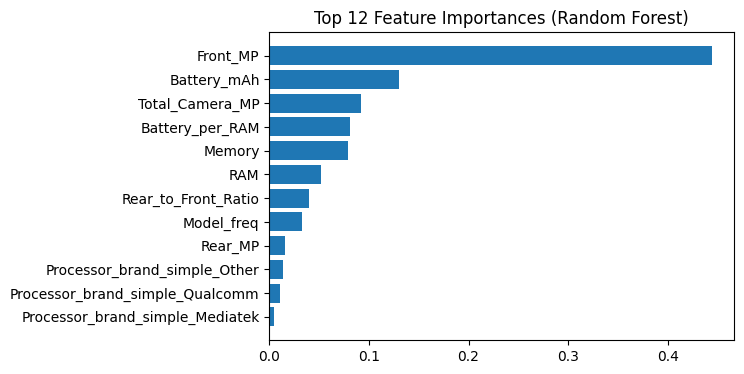

In [1126]:
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop features by Random Forest importance:\n", fi.head(15))
plt.figure(figsize=(6,4))
plt.barh(fi.head(12).index[::-1], fi.head(12).values[::-1])
plt.title('Top 12 Feature Importances (Random Forest)')
plt.show()

# Permutation importance (more robust)


Top features by Permutation importance:
 Front_MP                           0.817706
Battery_mAh                        0.204433
Total_Camera_MP                    0.116294
Battery_per_RAM                    0.040830
Memory                             0.039300
Rear_to_Front_Ratio                0.026418
Rear_MP                            0.011907
Processor_brand_simple_Other       0.008981
Processor_brand_simple_Mediatek    0.008000
Processor_brand_simple_Qualcomm    0.006364
Model_freq                         0.005563
RAM                                0.002015
Processor_brand_simple_Helio       0.000889
Colour_simple_Other                0.000604
Processor_brand_simple_Unisoc      0.000105
dtype: float64


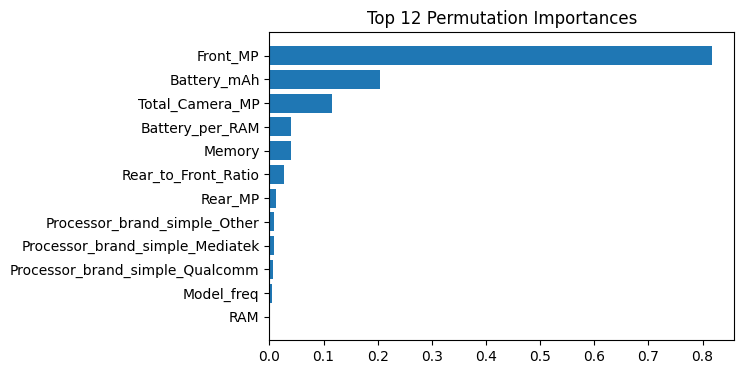

In [1127]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("\nTop features by Permutation importance:\n", perm_importances.head(15))

plt.figure(figsize=(6,4))
plt.barh(perm_importances.head(12).index[::-1], perm_importances.head(12).values[::-1])
plt.title('Top 12 Permutation Importances')
plt.show()

# ---------- Feature report ----------

In [1128]:
feature_report = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_,
    'perm_importance': perm.importances_mean
}).sort_values(by='rf_importance', ascending=False).reset_index(drop=True)

from IPython.display import display, HTML
display(HTML('<h3>Feature Importance Report</h3>'))
display(feature_report.head(30))

,feature,rf_importance,perm_importance
0,Front_MP,0.444607,8.177060e-01
1,Battery_mAh,0.130493,2.044335e-01
2,Total_Camera_MP,0.091724,1.162938e-01
3,Battery_per_RAM,0.081428,4.082975e-02
4,Memory,0.078904,3.930038e-02
5,RAM,0.052017,2.014627e-03
6,Rear_to_Front_Ratio,0.039652,2.641751e-02
7,Model_freq,0.032477,5.563261e-03
8,Rear_MP,0.015997,1.190746e-02
9,Processor_brand_simple_Other,0.013606,8.981442e-03


# ---------- Summary of findings ----------

In [1129]:
summary_text = f"""
Summary of Analysis:
- Dataset shape: {df.shape}
- Top correlated numeric features with Price (descending):\n{corr['Price'].sort_values(ascending=False).head(10)}
- Models trained: Linear Regression (baseline), Random Forest (stronger non-linear model).
- Best performance observed: Random Forest with RMSE = {results[1]['RMSE']:.2f}, MAE = {results[1]['MAE']:.2f}, R2 = {results[1]['R2']:.4f}.
- Top features (RF):\n{fi.head(10).to_string()}

Key engineered features added to the table: {present_new}. These columns are now part of the dataset and can be used for downstream analysis or reporting.
Recommendations:
1. Battery capacity, RAM, and combined camera MP are strong predictors of price — emphasize these in product listings and pricing strategy.
2. Use 'Model frequency' or brand-level features to capture model popularity which correlates with price.
3. Consider collecting additional features (e.g., screen type, refresh rate, warranty) to improve predictive power.
"""
print(summary_text)


Summary of Analysis:
- Dataset shape: (541, 22)
- Top correlated numeric features with Price (descending):
Price            1.000000
Memory           0.566660
Front_MP         0.532321
RAM              0.532024
Rear_MP          0.410367
Mobile Height    0.176009
Battery_mAh     -0.034297
Battery_        -0.034297
AI Lens         -0.153691
Name: Price, dtype: float64
- Models trained: Linear Regression (baseline), Random Forest (stronger non-linear model).
- Best performance observed: Random Forest with RMSE = 4503.82, MAE = 1590.82, R2 = 0.8528.
- Top features (RF):
Front_MP                        0.444607
Battery_mAh                     0.130493
Total_Camera_MP                 0.091724
Battery_per_RAM                 0.081428
Memory                          0.078904
RAM                             0.052017
Rear_to_Front_Ratio             0.039652
Model_freq                      0.032477
Rear_MP                         0.015997
Processor_brand_simple_Other    0.013606

Key engineered 

Save enhanced dataframe to disk for user's further use

In [1130]:
import os
out_path = os.path.join(os.getcwd(), "Processed_Flipdata_enhanced.csv")
df.to_csv(out_path, index=False)
print("Enhanced dataset saved to:", out_path)

Enhanced dataset saved to: d:\Projects\Data Science Project\Project 4\Processed_Flipdata_enhanced.csv


# Display final small sample and results table

In [1131]:
from IPython.display import display, HTML
display(HTML('<h3>Final Dataset Sample (saved)</h3>'))
display(df.sample(8))
results_df = pd.DataFrame(results)
display(HTML('<h3>Model Evaluation Results</h3>'))
display(results_df)

,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,...,Front_MP,Battery_mAh,Total_Camera_MP,Rear_to_Front_Ratio,Battery_per_RAM,Model_freq,Processor_brand,Price_bucket,Processor_brand_simple,Colour_simple
71,realme C30,Denim Black,32.0,3.0,5000.0,8MP,5MP,0.0,16.51,Unisoc T612,...,5.0,5000.0,13.0,1.600000,1666.666667,0.007394,Unisoc,Low,Unisoc,Other
168,realme 10,Clash White,128.0,8.0,5000.0,50MP,16MP,0.0,16.26,Mediatek Helio G99 Octa Core,...,16.0,5000.0,66.0,3.125000,625.000000,0.005545,Mediatek,High,Mediatek,Other
35,POCO C55,Cool Blue,128.0,6.0,5000.0,50MP,5MP,0.0,17.04,Mediatek Helio G85,...,5.0,5000.0,55.0,10.000000,833.333333,0.009242,Mediatek,Low,Mediatek,Cool Blue
319,OPPO Reno8T 5G,Midnight Black,128.0,8.0,4800.0,108MP,32MP,0.0,17.02,Qualcomm Snapdragon 695,...,32.0,4800.0,140.0,3.375000,600.000000,0.003697,Qualcomm,Premium,Qualcomm,Midnight Black
79,realme C55,Sunshower,128.0,8.0,5000.0,64MP,8MP,0.0,17.07,Helio G88,...,8.0,5000.0,72.0,8.000000,625.000000,0.016636,Helio,High,Helio,Other
13,SAMSUNG Galaxy F13,Waterfall Blue,128.0,4.0,6000.0,50MP,8MP,0.0,16.76,Exynos 850,...,8.0,6000.0,58.0,6.250000,1500.000000,0.011091,Exynos,Medium,Other,Other
111,POCO X5 5G,Supernova Green,128.0,6.0,5000.0,48MP,13MP,0.0,16.94,Qualcomm Snapdragon 695,...,13.0,5000.0,61.0,3.692308,833.333333,0.009242,Qualcomm,High,Qualcomm,Other
289,POCO M4 5G,Cool Blue,128.0,6.0,5000.0,50MP,8MP,0.0,16.71,Mediatek Dimensity 700,...,8.0,5000.0,58.0,6.250000,833.333333,0.009242,Mediatek,High,Mediatek,Cool Blue


,model,MAE,RMSE,R2
0,LinearRegression,4239.504387,8960.933616,0.417401
1,RandomForest,1590.824502,4503.816868,0.852828


# Provide download link for the enhanced dataset

In [1132]:
print(f"[Download the enhanced CSV](/mnt/data/Processed_Flipdata_enhanced.csv)")

[Download the enhanced CSV](/mnt/data/Processed_Flipdata_enhanced.csv)


Continued (streamlined) run to finish analysis cleanly (avoiding long plotting operations).

In [1133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Loading the original file

In [1134]:
import os
file_path = os.path.join(os.getcwd(), "Processed_Flipdata.xlsx")
df = pd.read_excel(file_path)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.columns = [c.strip() for c in df.columns]
if 'Prize' in df.columns:
    df.rename(columns={'Prize':'Price'}, inplace=True)

# Convert camera MP and battery

In [1135]:
def mp_to_num(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).upper().replace("MP","").replace(" ","")
        return float(s)
    except:
        return np.nan

if 'Rear Camera' in df.columns:
    df['Rear_MP'] = df['Rear Camera'].apply(mp_to_num)
if 'Front Camera' in df.columns:
    df['Front_MP'] = df['Front Camera'].apply(mp_to_num)
if 'Battery_' in df.columns:
    df['Battery_mAh'] = pd.to_numeric(df['Battery_'], errors='coerce')
for col in ['Memory','RAM','AI Lens','Mobile Height']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Impute numeric with median

In [1136]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df.fillna('Unknown', inplace=True)

# Feature engineering (same as before)

In [1137]:
if 'Rear_MP' in df.columns and 'Front_MP' in df.columns:
    df['Total_Camera_MP'] = df['Rear_MP'] + df['Front_MP']
    df['Rear_to_Front_Ratio'] = df['Rear_MP'] / (df['Front_MP'].replace({0:np.nan}))
    df['Rear_to_Front_Ratio'] = df['Rear_to_Front_Ratio'].fillna(0)
if 'Battery_mAh' in df.columns and 'RAM' in df.columns:
    df['Battery_per_RAM'] = df['Battery_mAh'] / (df['RAM'].replace({0:np.nan}))
    df['Battery_per_RAM'] = df['Battery_per_RAM'].fillna(df['Battery_per_RAM'].median())
if 'Model' in df.columns:
    freq = df['Model'].value_counts(normalize=True)
    df['Model_freq'] = df['Model'].map(freq)
if 'Processor_' in df.columns:
    df['Processor_brand'] = df['Processor_'].apply(lambda x: str(x).split()[0] if pd.notna(x) else 'Unknown')
df['Price_bucket'] = pd.qcut(df['Price'], q=4, labels=['Low','Medium','High','Premium'])

# Prepare features

In [1138]:
feature_candidates = [c for c in ['Battery_mAh','RAM','Memory','Rear_MP','Front_MP','Total_Camera_MP','Rear_to_Front_Ratio','Battery_per_RAM','Model_freq'] if c in df.columns]
top_proc = df['Processor_brand'].value_counts().nlargest(6).index.tolist() if 'Processor_brand' in df.columns else []
df['Processor_brand_simple'] = df['Processor_brand'].apply(lambda x: x if x in top_proc else 'Other')
top_col = df['Colour'].value_counts().nlargest(8).index.tolist() if 'Colour' in df.columns else []
df['Colour_simple'] = df['Colour'].apply(lambda x: x if x in top_col else 'Other')

X_num = df[feature_candidates].copy()
X_cat = df[['Processor_brand_simple','Colour_simple']].copy()
X = pd.concat([X_num, pd.get_dummies(X_cat, drop_first=True)], axis=1)
y = df['Price']

# Train/test split

In [1139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Models

In [1140]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def eval_preds(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'model':name, 'MAE':mae, 'RMSE':rmse, 'R2':r2}

results = [eval_preds(y_test, y_pred_lr, 'LinearRegression'), eval_preds(y_test, y_pred_rf, 'RandomForest')]
results_df = pd.DataFrame(results)
from IPython.display import display, HTML
display(HTML('<h3>Model Evaluation Results (streamlined)</h3>'))
display(results_df)

,model,MAE,RMSE,R2
0,LinearRegression,4239.504387,8960.933616,0.417401
1,RandomForest,1557.540865,4295.618279,0.866120


# Feature importance

In [1141]:
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
from IPython.display import display, HTML
display(HTML('<h3>Top 20 Feature Importances (RF)</h3>'))
display(fi.head(20).reset_index().rename(columns={'index':'feature',0:'importance'}))

,feature,importance
0,Front_MP,0.468722
1,Battery_mAh,0.133104
2,Total_Camera_MP,0.093700
3,Battery_per_RAM,0.080784
4,Memory,0.071852
5,RAM,0.036431
6,Rear_to_Front_Ratio,0.033724
7,Model_freq,0.030871
8,Rear_MP,0.017711
9,Processor_brand_simple_Other,0.013852


# Permutation importance quick

In [1142]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=8, random_state=42, n_jobs=1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
from IPython.display import display, HTML
display(HTML('<h3>Top 20 Permutation Importances</h3>'))
display(perm_importances.head(20).reset_index().rename(columns={'index':'feature',0:'perm_importance'}))

,feature,perm_importance
0,Front_MP,8.480162e-01
1,Battery_mAh,2.023971e-01
2,Total_Camera_MP,1.254678e-01
3,Battery_per_RAM,5.262438e-02
4,Memory,4.222954e-02
5,Rear_to_Front_Ratio,2.572732e-02
6,Model_freq,1.294580e-02
7,Rear_MP,1.037250e-02
8,Processor_brand_simple_Other,9.375063e-03
9,Processor_brand_simple_Mediatek,7.952776e-03


# Save enhanced CSV

In [1143]:
import os
out_path = os.path.join(os.getcwd(), "Processed_Flipdata_enhanced.csv")
df.to_csv(out_path, index=False)
print("Enhanced dataset saved to:", out_path)
print(f"[Download the enhanced CSV]({out_path})")

Enhanced dataset saved to: d:\Projects\Data Science Project\Project 4\Processed_Flipdata_enhanced.csv
[Download the enhanced CSV](d:\Projects\Data Science Project\Project 4\Processed_Flipdata_enhanced.csv)


# Show a short summary text

In [1144]:
summary = f"""
Quick Summary:
- Rows: {df.shape[0]}, Columns: {df.shape[1]}
- Features engineered and added to dataset: Total_Camera_MP, Rear_to_Front_Ratio, Battery_per_RAM, Model_freq, Processor_brand, Price_bucket
- Random Forest performance (RMSE): {results_df.loc[results_df['model']=='RandomForest','RMSE'].values[0]:.2f}, R2: {results_df.loc[results_df['model']=='RandomForest','R2'].values[0]:.4f}
- Top RF features: {', '.join(fi.head(6).index.tolist())}
"""
print(summary)


Quick Summary:
- Rows: 541, Columns: 22
- Features engineered and added to dataset: Total_Camera_MP, Rear_to_Front_Ratio, Battery_per_RAM, Model_freq, Processor_brand, Price_bucket
- Random Forest performance (RMSE): 4295.62, R2: 0.8661
- Top RF features: Front_MP, Battery_mAh, Total_Camera_MP, Battery_per_RAM, Memory, RAM



# Display a small sample of enhanced dataset

In [1145]:
from IPython.display import display, HTML
display(HTML('<h3>Enhanced Dataset Sample</h3>'))
display(df.sample(8))

,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,...,Front_MP,Battery_mAh,Total_Camera_MP,Rear_to_Front_Ratio,Battery_per_RAM,Model_freq,Processor_brand,Price_bucket,Processor_brand_simple,Colour_simple
149,REDMI Note 12 5G,Matte Black,128.0,4.0,5000.0,48MP,13MP,0.0,16.94,Qualcomm Snapdragon 4 Gen 1,...,13.0,5000.0,61.0,3.692308,1250.0,0.011091,Qualcomm,High,Qualcomm,Other
479,POCO C31,Royal Blue,64.0,4.0,5000.0,13MP,5MP,0.0,16.59,MediaTek G35,...,5.0,5000.0,18.0,2.600000,1250.0,0.007394,MediaTek,Low,MediaTek,Royal Blue
60,SAMSUNG Galaxy F13,Sunrise Copper,64.0,4.0,6000.0,50MP,8MP,0.0,16.76,Exynos 850,...,8.0,6000.0,58.0,6.250000,1500.0,0.011091,Exynos,Medium,Other,Other
124,Infinix Smart 7 HD,Jade White,64.0,2.0,5000.0,8MP,5MP,1.0,16.76,Spreadtrum SC9863A1,...,5.0,5000.0,13.0,1.600000,2500.0,0.007394,Spreadtrum,Low,Other,Other
255,REDMI Note 12 Pro+ 5G,Arctic White,256.0,8.0,4980.0,200MP,16MP,0.0,16.94,Mediatek Dimensity 1080,...,16.0,4980.0,216.0,12.500000,622.5,0.011091,Mediatek,Premium,Mediatek,Other
54,vivo T2 5G,Nitro Blaze,128.0,6.0,4500.0,32MP,16MP,0.0,16.21,Snapdragon 695,...,16.0,4500.0,48.0,2.000000,750.0,0.007394,Snapdragon,High,Other,Other
219,MOTOROLA e13,Aurora Green,64.0,2.0,5000.0,13MP,5MP,0.0,16.51,Unisoc T606,...,5.0,5000.0,18.0,2.600000,2500.0,0.009242,Unisoc,Low,Unisoc,Other
295,realme 8,Punk Black,128.0,4.0,5000.0,64MP,16MP,0.0,16.26,MediaTek Helio G95,...,16.0,5000.0,80.0,4.000000,1250.0,0.003697,MediaTek,Medium,MediaTek,Other
